## CODE TO CALCULATE PBL HEIGHT AND LCL FROM RAMAN LIDAR DATA
#### AUTHOR: Claudia Acquistapace
#### DATE: 2022-01-14
#### GOAL: read raman lidar profiles and calculate PBLH using richardson's number method
methodology used:
1) read surface pressure from ship data
2) read T, q profiles from arthus data and horizontal wind from wind lidar
3) resample all data on the coarser resolution of the horizontal wind data
4) extrapolate pressure profile using hydrostatic equation
5) calculating RH at surface and profile, and virtual potential temperature matrix
6) calculating U and V component from ECMWF formula using horizontal wind speed and direction
7) calculate lowest height where we have data in ARTHUS/wind lidar
8) derive LCL using P surface ship , T, RH from Arthus data at lowest detected heigth
9) calculate PBLH using bulk richardson number from eq 1 in https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2012JD018143
10) 

##

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [2]:


# Version 1.0 released by David Romps on September 12, 2017.
# 
# When using this code, please cite:
# 
# @article{16lcl,
#   Title   = {Exact expression for the lifting condensation level},
#   Author  = {David M. Romps},
#   Journal = {Journal of the Atmospheric Sciences},
#   Year    = {2017},
#   Volume  = {in press},
# }
#
# This lcl function returns the height of the lifting condensation level
# (LCL) in meters.  The inputs are:
# - p in Pascals
# - T in Kelvins
# - Exactly one of rh, rhl, and rhs (dimensionless, from 0 to 1):
#    * The value of rh is interpreted to be the relative humidity with
#      respect to liquid water if T >= 273.15 K and with respect to ice if
#      T < 273.15 K. 
#    * The value of rhl is interpreted to be the relative humidity with
#      respect to liquid water
#    * The value of rhs is interpreted to be the relative humidity with
#      respect to ice
# - ldl is an optional logical flag.  If true, the lifting deposition
#   level (LDL) is returned instead of the LCL. 
# - min_lcl_ldl is an optional logical flag.  If true, the minimum of the
#   LCL and LDL is returned.
def lcl(p,T,rh=None,rhl=None,rhs=None,return_ldl=False,return_min_lcl_ldl=False):

    import math
    import scipy.special
    import numpy as np 
    
    # Parameters
    Ttrip = 273.16     # K
    ptrip = 611.65     # Pa
    E0v   = 2.3740e6   # J/kg
    E0s   = 0.3337e6   # J/kg
    ggr   = 9.81       # m/s^2
    rgasa = 287.04     # J/kg/K 
    rgasv = 461        # J/kg/K 
    cva   = 719        # J/kg/K
    cvv   = 1418       # J/kg/K 
    cvl   = 4119       # J/kg/K 
    cvs   = 1861       # J/kg/K 
    cpa   = cva + rgasa
    cpv   = cvv + rgasv

    # The saturation vapor pressure over liquid water
    def pvstarl(T):
        return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * \
         math.exp( (E0v - (cvv-cvl)*Ttrip) / rgasv * (1/Ttrip - 1/T) )
   
    # The saturation vapor pressure over solid ice
    def pvstars(T):
        return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) * \
         math.exp( (E0v + E0s - (cvv-cvs)*Ttrip) / rgasv * (1/Ttrip - 1/T) )

    # Calculate pv from rh, rhl, or rhs
    rh_counter = 0
    if rh  is not None:
        rh_counter = rh_counter + 1
    if rhl is not None:
        rh_counter = rh_counter + 1
    if rhs is not None:
        rh_counter = rh_counter + 1
    if rh_counter != 1:
        print(rh_counter)
        exit('Error in lcl: Exactly one of rh, rhl, and rhs must be specified')
    if rh is not None:
        # The variable rh is assumed to be 
        # with respect to liquid if T > Ttrip and 
        # with respect to solid if T < Ttrip
        if T > Ttrip:
            pv = rh * pvstarl(T)
        else:
            pv = rh * pvstars(T)
        rhl = pv / pvstarl(T)
        rhs = pv / pvstars(T)
    elif rhl is not None:
        pv = rhl * pvstarl(T)
        rhs = pv / pvstars(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    elif rhs is not None:
        pv = rhs * pvstars(T)
        rhl = pv / pvstarl(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    if pv > p:
        return np.nan

    # Calculate lcl_liquid and lcl_solid
    qv = rgasa*pv / (rgasv*p + (rgasa-rgasv)*pv)
    rgasm = (1-qv)*rgasa + qv*rgasv
    cpm = (1-qv)*cpa + qv*cpv
    if rh == 0:
        return cpm*T/ggr
    aL = -(cpv-cvl)/rgasv + cpm/rgasm
    bL = -(E0v-(cvv-cvl)*Ttrip)/(rgasv*T)
    cL = pv/pvstarl(T)*math.exp(-(E0v-(cvv-cvl)*Ttrip)/(rgasv*T))
    aS = -(cpv-cvs)/rgasv + cpm/rgasm
    bS = -(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T)
    cS = pv/pvstars(T)*math.exp(-(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T))
    lcl = cpm*T/ggr*( 1 - \
       bL/(aL*scipy.special.lambertw(bL/aL*cL**(1/aL),-1).real) )
    ldl = cpm*T/ggr*( 1 - \
      bS/(aS*scipy.special.lambertw(bS/aS*cS**(1/aS),-1).real) )

    # Return either lcl or ldl
    if return_ldl and return_min_lcl_ldl:
        exit('return_ldl and return_min_lcl_ldl cannot both be true')
    elif return_ldl:
        return ldl
    elif return_min_lcl_ldl:
        return min(lcl,ldl)
    else:
        return lcl
    

In [3]:
# we get pressure at surface ( in Pa) from ship data
file_ship = '/Volumes/Extreme SSD/ship_motion_correction_merian/ship_data/new/ship_dataset_allvariables.nc'
ship_data = xr.open_dataset(file_ship)

# select time interval of interest
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing  dataset for the selected time interval and extracting P
slice_ship_data = ship_data.sel(time=slice(t_start, t_end))


In [4]:
# getting now temperature in kelvin and relative humidity, and horizontal wind speed from raman lidar and wind lidar
arthus_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'


# reading file list of the files for the selected variable
arthus_file_list_T = np.sort(glob.glob(arthus_path+'T*.nc'))

# read the two datasets together
arthus_T_base = xr.open_mfdataset(arthus_file_list_T)


# reading file list of the files for the selected variable
arthus_file_list_MR = np.sort(glob.glob(arthus_path+'MR*.nc'))

# read the two datasets together
arthus_MR_base = xr.open_mfdataset(arthus_file_list_MR)


# read the wind dataset 
arthus_file_list_Hwind = np.sort(glob.glob(arthus_path+'H_wind_speed_dir*.nc'))
arthus_H_wind = xr.open_mfdataset(arthus_file_list_Hwind)

# interpolating all arthus data on the horizontal wind data from the wind lidar ( lower resolution in time and height)
arthus_MR_t = arthus_MR_base.interp(time=arthus_H_wind.time.values)
arthus_T_t = arthus_T_base.interp(time=arthus_H_wind.time.values)

# interpolating all arthus data on the horizontal wind data for height
arthus_MR = arthus_MR_t.interp(height=arthus_H_wind.height.values)
arthus_T = arthus_T_t.interp(height=arthus_H_wind.height.values)

# interpolate pressure on the time grid of the horizontal wind data
ship_arthus = slice_ship_data.interp(time=arthus_H_wind.time.values)

# dimensions for time and height to use in the next 
dim_time = len(arthus_H_wind.time.values)
dim_height = len(arthus_H_wind.height.values)
time = arthus_H_wind.time.values
height = arthus_H_wind.height.values



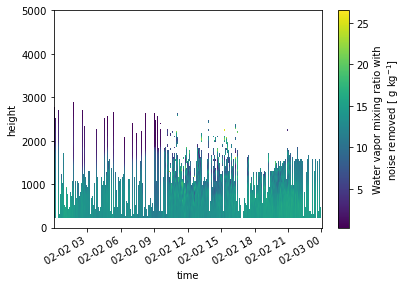

In [5]:
arthus_MR.product_no_noise.plot(x='time', y='height')


In [6]:
# calculating pressure profiles using hydrostatic equation, T and RH profiles from Arthus to estimate Tv mean and surface measured pressure.
P_matrix = np.zeros((dim_time, dim_height))
P_matrix.fill(np.nan)


# calculating virtual temperature using lidar data
Tv = arthus_T.product_no_noise.values * (1 + 0.61 *arthus_MR.product_no_noise.values* 10**(-3))

# calculating mean temperature in the first 2500 m  
dims   = ['time', 'height']
coords = {"time":arthus_T.time.values, "height":arthus_T.height.values}
Tv_data    = xr.DataArray(dims=dims, coords=coords, data=Tv,
                 attrs={'long_name':'virtual temperature',
                        'units':'$^{\circ}$K'})
arthus_T['Tv'] = Tv_data

# selecting only heights below 3000m and calculate Tv mean over this height interval
arthus_sel_h = arthus_T.sel(height=slice(0., 2975.))

# calculating mean Tv for each time stamp
arthus_mean = arthus_sel_h.mean(dim='height', skipna=True)
Tv_mean = arthus_mean.Tv.values

# reading surface pressure from ship data re-sampled
P_surf = ship_arthus.P.values


# calculating hydrostatic pressure
g = 9.8 # ms-2
Rd = 287  # J (Kg K)-1
for ind_height in range(dim_height):
    P_matrix[:,ind_height] = P_surf * np.exp( - (g *(height[ind_height]-20.))/(Rd*Tv_mean))
    

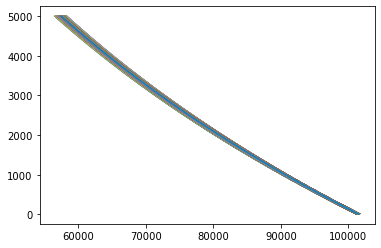

In [7]:
for ind_t in range(dim_time):
    plt.plot(P_matrix[ind_t,:], height)

In [8]:
# deriving relative humidity at the surface and theta and theta_v at surface necessary in Ri calculation 
RH_surf = ship_arthus.RH.values
T_surf = ship_arthus.T.values
P_surf = ship_arthus.P.values
print(RH_surf)
# saturation vapor pressure ( formula 4.2 pag 89 from Practical meteorology, Stull, tetens' formula)
e_s_surf = 611.3 * np.exp((17.2694 * (T_surf - 273.15))/(T_surf - 35.86)) # [Pa]

# partial water vapor pressure (from RH definition RH = e/es, stull, pag 92, Moisture variables)
e_surf = RH_surf * e_s_surf

# calculation of mixing ratio at the surface
epsilon = 622 # [g kg-1] Rd/Rv
mr_surf = (epsilon * e_surf)/(P_surf- e_surf)

# calculation of theta_v at surface
theta_v_s = T_surf * (1 + 0.61 * mr_surf * 0.001)
theta_v_s

[0.727      0.717      0.726      0.746      0.741      0.6994395
 0.711      0.69456034 0.714886   0.728      0.73       0.72116448
 0.728      0.746552   0.73197399 0.716      0.71009    0.705
 0.715888   0.71926467 0.706      0.679      0.7037555  0.7
 0.69782567 0.687      0.7        0.69844683 0.715      0.706
 0.704501   0.716      0.716      0.729      0.736      0.732
 0.758657   0.748      0.751      0.755      0.76       0.751
 0.74789317 0.744      0.737      0.738      0.735      0.759
 0.749      0.741      0.755      0.749      0.729      0.73743167
 0.726      0.73002017 0.742626   0.726      0.7294465  0.7521885
 0.731      0.73772583 0.7378685  0.726      0.741      0.741
 0.74005967 0.713      0.697      0.71126833 0.72       0.725
 0.71441968 0.715      0.72       0.702      0.707      0.727
 0.70191002 0.686      0.702      0.70476134 0.715      0.708
 0.701016   0.712      0.711      0.728      0.708      0.722
 0.716      0.732      0.701      0.709      0.692    

array([302.90400013, 302.74356759, 302.78112085, 303.10262438,
       302.96239169, 302.67122746, 302.83733835, 302.53330367,
       302.73481987, 302.90816902, 302.91620737, 302.64233302,
       302.67045181, 303.10463424, 302.92443791, 302.85786771,
       302.83354923, 302.93002492, 302.97594308, 303.10854237,
       303.05259035, 302.93858451, 302.92481256, 303.26404096,
       303.01784662, 303.09050066, 303.38227415, 302.90229505,
       303.2089785 , 303.2893653 , 303.16441754, 302.85727934,
       302.62051648, 302.9114387 , 302.70278025, 302.92424523,
       303.15520009, 302.63341716, 302.7645543 , 302.78103843,
       302.92116395, 302.7645543 , 302.75175415, 302.73571827,
       302.70659724, 302.71071334, 302.69836591, 303.15632749,
       302.75631398, 302.60447282, 302.90041718, 302.75661842,
       302.55569839, 302.70897292, 302.54343646, 302.67846823,
       302.84971217, 302.66222314, 302.55781782, 302.8893702 ,
       302.44564901, 302.67789993, 302.94962947, 302.66

In [9]:
#  calculating profiles from mixing ratio and saturation vapor pressure from arthus data

# calculating potential temperature matrix from Arthus data
mr = arthus_MR.product_no_noise.values * 10.**(-3) # to convert from g/kg to g/g
T = arthus_T.product_no_noise.values # [K]

# calculating profiles of virtual potential temperature
Theta_v = np.zeros((dim_time, dim_height))
Cp = 1004. # [J Kg-1 K-1]
Rd = 287.058  # gas constant for dry air [Kg-1 K-1 J]
    
for indHeight in range(dim_height):
    k = Rd*(1-0.23*mr[:, indHeight])/Cp
    Theta_v[:,indHeight] = ( (1 + 0.61 * mr[:, indHeight]) * T[:, indHeight] * (P_surf/P_matrix[:,indHeight])**k)




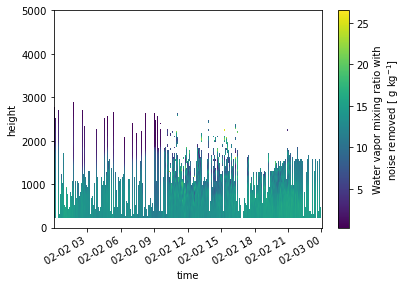

In [10]:
arthus_MR.product_no_noise.plot(x='time', y='height')

In [11]:
# calculating U and V components and adding them to the H wind xarray
wspd = arthus_H_wind.H_speed_no_noise.values
wdir = arthus_H_wind.H_dir_no_noise.values

# calculating u and v components from wind speed and wind direction
U_matrix = np.zeros((dim_time, dim_height))
U_matrix.fill(np.nan)
V_matrix = np.zeros((dim_time, dim_height))
V_matrix.fill(np.nan)

for ind_height in range(dim_height):
    U_matrix[:, ind_height] = - wspd[:,ind_height] * np.sin(wdir[:,ind_height])
    V_matrix[:, ind_height] = - wspd[:,ind_height] * np.cos(wdir[:,ind_height])
    

# adding U and V to the arthus_H_wind xarray dataset
dims   = ['time', 'height']
coords = {"time":arthus_H_wind.time.values, "height":arthus_H_wind.height.values}
U_data    = xr.DataArray(dims=dims, coords=coords, data=U_matrix,
                 attrs={'long_name':'U',
                        'units':'ms$^{-1}$'})
V_data    = xr.DataArray(dims=dims, coords=coords, data=V_matrix,
                 attrs={'long_name':'V',
                        'units':'ms$^{-1}$'})
theta_v_data = xr.DataArray(dims=dims, coords=coords, data=Theta_v,
                 attrs={'long_name':'Theta_v',
                        'units':"K"}) 
arthus_H_wind['U'] = U_data
arthus_H_wind['V'] = V_data
arthus_H_wind['theta_v'] = theta_v_data

(250.0, 2000.0)

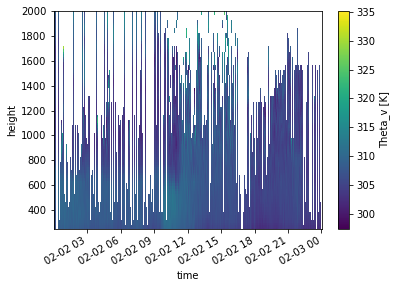

In [12]:
arthus_H_wind.theta_v.plot(x='time', y='height')
plt.ylim(250., 2000.)

(0.0, 2000.0)

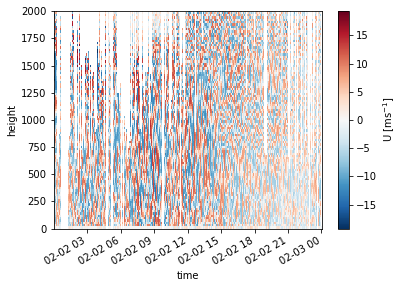

In [13]:
arthus_H_wind.U.plot(x='time', y='height')
plt.ylim(0., 2000.)

(0.0, 2000.0)

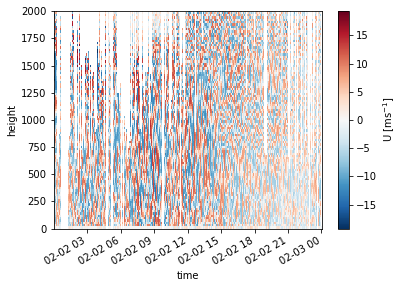

In [14]:
arthus_H_wind.U.plot(x='time', y='height')
plt.ylim(0., 2000.)

In [15]:
# ------------------------------------------------------------------------------
# calculating LCL height
# important: provide pressure in Pascals, T in K, RH in 0.703
#---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------   
z_lcl = np.zeros((len(P_surf)))
for ind_time in range(len(P_surf)):
    #print(P_surf[ind_time], T_surf[ind_time], RH_surf[ind_time]/100.)
    #print(lcl(P_surf[ind_time],T_surf[ind_time],RH_surf[ind_time]/100.))
    z_lcl[ind_time] = round(lcl(np.array(P_surf[ind_time]),np.array(T_surf[ind_time]),np.array(RH_surf[ind_time])), 2)
#print(z_lcl[ind_file])


In [16]:
# calculating matrix of Richardson numbers
Ri = np.zeros((dim_time, dim_height))
Ri.fill(np.nan)

U = arthus_H_wind.U.values
V = arthus_H_wind.V.values

# calculation of bulk richardson number profile (time serie for each height)
for iHeight in range(dim_height):
    
    # calculating denominator
    den = (U[:,iHeight])**2 + (V[:,iHeight])**2
    
    # setting to zero Ri where den is nan
    ind_good = np.where(~np.isnan(den))[0]
    Ri[~ind_good,iHeight] = 0.
    
    # calculating Ri where den is not nan
    Ri[ind_good,iHeight] = (1/den[ind_good]) * (g/theta_v_s[ind_good]) * (Theta_v[ind_good,iHeight]-theta_v_s[ind_good])*(height[iHeight])


    

In [17]:
# plot matrix of Ri by adding Ri to arthus_H_wind
arthus_H_wind['Ri'] = xr.DataArray(dims=dims, coords=coords, data=Ri,
                 attrs={'long_name':'Ri',
                        'units':"K"}) 

(250.0, 2000.0)

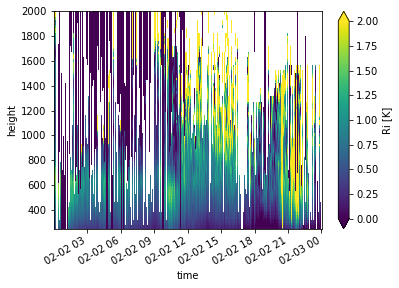

In [18]:
arthus_H_wind['Ri'].plot(x='time', y='height', vmin=0., vmax=2.)
plt.ylim(250., 2000.)

In [19]:
# find PBL height at height index where Ri > Rithreshold
Rithreshold = 0.3 #0.25                                    # Threshold values for Ri

PBLheight = np.zeros((dim_time))
for ind_time in range(dim_time):
    
    RiCol = Ri[ind_time, :]

    #print(np.where(RiCol > Rithreshold)[0][:])
    if len(np.where(RiCol > Rithreshold)[0][:]) != 0:
        PBLheight[ind_time] = height[np.where(RiCol > Rithreshold)[0][0]]
        #print('pbl height = ',height[np.where(RiCol > Rithreshold)[0][0]])
    else:
        PBLheight[ind_time] = 0.
    #print('pbl height = ',0)
#print(PBLheight[ind_file])

In [20]:
# read tsg data for SST temperature
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# interpolating SST on the arthus_H_wind data
sst_arthus = SST_DS.interp(time=time)

In [21]:
# calculating PBLH using the wind lidar data
# read wind lidar data
path_wind_lidar = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/"
file_list = np.sort(glob.glob(path_wind_lidar+'VW*.nc'))
wind_lidar = xr.open_mfdataset(file_list)


In [22]:
wind_lidar

<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2021-12-08 17:27:02.688157
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  Vertical velocitywith the diurnal cycle removed from t...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       arthus data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  arthus raman lidar system
    COMMENT:           original data postprocessed by Diego Lange

In [24]:
w = wind_lidar.product_no_noise.values
time = wind_lidar.time.values


# creating time grid of 5 minutes
from datetime import datetime, timedelta
time_grid = np.arange(t_start, t_end, timedelta(minutes=5))
dim_std = len(time_grid)
dim_height = len(wind_lidar.height.values)
w_std = np.zeros((dim_std, dim_height))

for i_time in range(3,len(time_grid)-3):
    
    ind_std = np.where((time > time_grid[i_time-3]) * (time <= time_grid[i_time+2]))[0]
    for i_height in range(dim_height):
        
        w_std[i_time,i_height] = np.nanstd(w[ind_std,i_height])
    




/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


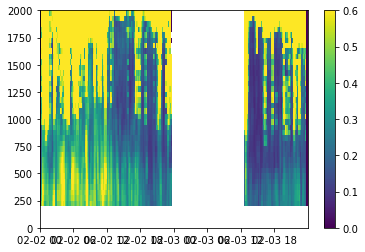

In [26]:
plt.pcolormesh(time_grid, wind_lidar.height.values, w_std.T, vmin=0.0, vmax=0.6)
plt.ylim(0., 2000.)
plt.colorbar()

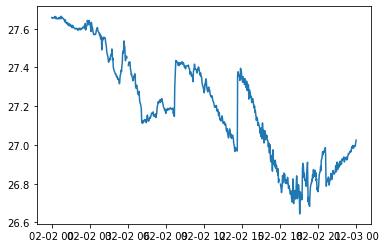

In [27]:
plt.plot(sst_arthus.time.values, sst_arthus.SST.values)


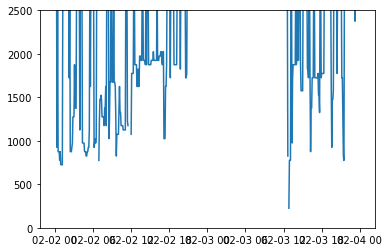

In [37]:
sigma_thr = 0.4 # Threshold by Tucker
PBL_sigma = np.zeros((len(time_grid)))
# calculating PBL height as a threshold on the standard deviation of w
for i_time in range(len(time_grid)):
    
    # finding PBLH as where sigma falls below sigma_thr
    ind_sel = np.where(w_std[i_time,:]<sigma_thr)[0]
    #print(wind_lidar.height.values[ind_sel])
    if len(ind_sel) > 0:
        PBL_sigma[i_time] = np.nanmax(wind_lidar.height.values[ind_sel])
    else:
        PBL_sigma[i_time] = np.nan

plt.plot(time_grid, PBL_sigma)
plt.ylim(0., 2500.)


# regridding sst data on PBLH_Sigma res
sst_arthus_interp = sst_arthus.interp(time=time_grid)
sst_arthus_interp['PBLS_sigma'] = PBL_sigma

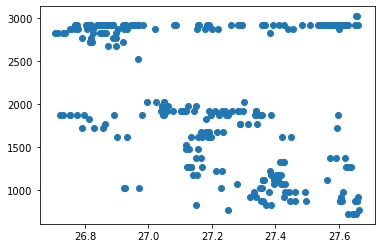

In [39]:
plt.scatter(sst_arthus_interp.SST.values, sst_arthus_interp.PBLS_sigma.values)

In [60]:
# create output dataset of PBLH and LCL 
dims              = ['time','height']
coords         = {"time":time, "height":height}
U_data    = xr.DataArray(dims=dims, coords=coords, data=U_matrix,
                 attrs={'long_name':'U',
                        'units':'ms$^{-1}$'})
V_data    = xr.DataArray(dims=dims, coords=coords, data=V_matrix,
                 attrs={'long_name':'V',
                        'units':'ms$^{-1}$'})
theta_v_data = xr.DataArray(dims=dims, coords=coords, data=Theta_v,
                 attrs={'long_name':'Theta_v',
                        'units':"K"}) 
theta_v_s_data = xr.DataArray(dims=['time'], coords={"time":time}, data=theta_v_s,
                 attrs={'long_name':'Theta_v_surface',
                        'units':"K"}) 
PBLH_RN = xr.DataArray(dims=['time'], coords={"time":time}, data=PBLheight,
                 attrs={'long_name':'PBLH_bulk_richardson',
                        'units':"m"}) 
LCL = xr.DataArray(dims=['time'], coords={"time":time}, data=z_lcl,
                 attrs={'long_name':'LCL height',
                        'units':"m"}) 
SST_data = xr.DataArray(dims=['time'], coords={"time":time}, data=sst_arthus.SST.values,
                 attrs={'long_name':'SST',
                        'units':"C"}) 
 
variables         = {'U':U_data,
                     'V':V_data,
                     'theta_v':theta_v_data,
                     'Theta_v_surf':theta_v_s_data,
                     'lcl':LCL,
                     'pblh_rn':PBLH_RN, 
                      'SST':SST_data}

sst_binned_PBLH_arthus = xr.Dataset(data_vars = variables,
                       coords = coords)

sst_binned_PBLH_arthus


<xarray.Dataset>
Dimensions:       (height: 236, time: 864)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-02T00:01:02.282835 ... 2020-0...
  * height        (height) float64 10.6 31.81 53.02 ... 4.974e+03 4.995e+03
Data variables:
    U             (time, height) float64 0.3141 nan nan nan ... nan nan nan nan
    V             (time, height) float64 0.3861 nan nan nan ... nan nan nan nan
    theta_v       (time, height) float64 nan nan nan nan nan ... nan nan nan nan
    Theta_v_surf  (time) float64 302.9 302.7 302.8 303.1 ... 302.9 302.8 302.7
    lcl           (time) float64 684.0 712.0 686.2 630.9 ... 706.5 706.2 735.2
    pblh_rn       (time) float64 0.0 243.9 243.9 243.9 243.9 ... 0.0 0.0 0.0 0.0
    SST           (time) float64 27.66 27.66 27.65 27.66 ... 27.0 27.02 27.02

In [61]:
# building SST bins and grouping the data
bin_size = 0.25
SST_binned_arr = np.round(np.arange(np.nanmin(sst_arthus.SST.values),np.nanmax(sst_arthus.SST.values), bin_size),1)
SST_binned_arr


#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(SST_binned_arr)))



In [65]:
dataset_mean = []
# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = sst_binned_PBLH_arthus.where((sst_binned_PBLH_arthus.SST > SST_binned_arr[ind_bin]) \
                                  & (sst_binned_PBLH_arthus.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))

# concatenating datasets corresponding to SST bins on a new bin dimension
dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')

path_out = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/'

#sst_binned_PBLH_arthus_new = sst_binned_PBLH_arthus.reindex(sst=sorted(sst_binned_PBLH_arthus.sst.values))
#sst_binned_PBLH_arthus_new.to_netcdf(path_out+'PBLH_arthus_binned_sst.nc')
dataset_concat

<xarray.Dataset>
Dimensions:       (SST_binned: 4, height: 236)
Coordinates:
  * height        (height) float64 10.6 31.81 53.02 ... 4.974e+03 4.995e+03
Dimensions without coordinates: SST_binned
Data variables:
    U             (SST_binned, height) float64 -0.007836 -0.2927 ... nan nan
    V             (SST_binned, height) float64 0.8272 0.1762 -0.1315 ... nan nan
    theta_v       (SST_binned, height) float64 nan nan nan nan ... nan nan nan
    Theta_v_surf  (SST_binned) float64 303.3 303.1 302.7 302.5
    lcl           (SST_binned) float64 810.2 827.1 893.6 820.2
    pblh_rn       (SST_binned) float64 370.9 280.2 260.9 224.8
    SST           (SST_binned) float64 26.81 26.98 27.25 27.49
    n_elements    (SST_binned) float64 172.0 143.0 310.0 132.0

In [67]:
SST_binned_arr

array([26.6, 26.9, 27.1, 27.4, 27.6])

In [ ]:
def f_calcPblHeightRN(thetaV,Uwind,Vwind,height,time,device):
    """
    PBL height calculation function
    --------------------------------------------------------------------------------
    date created :  15.01.2018
    date modifed :  05.12.2019
    author: Claudia Acquistapace
    goal: calculate the boundary layer height following the richardson number
    derivation according to Seidel Et al, 2010
    #---------------------------------------------------------------------------------
    """
    g            = 9.8        # gravity constant
    Rithreshold  = 0.25       # Threshold values for Ri
    #Rithreshold2 = 0.2
    dimTime      = len(time)
    dimHeight    = len(height)
    if (device == 'mod'):
        zs       = height[149]                                        # height of the surface reference
    if (device == 'obs'):
        zs       = height[0]
    RiMatrix     = np.zeros((dimTime, dimHeight))                    # Richardson number matrix
    PBLheightArr = []
    RiCol        = np.zeros((dimHeight))
    
    # calculating richardson number matrix
    for iTime in range(dimTime):
        thetaS = thetaV[iTime,149]
        for iHeight in range(dimHeight):
            den = ((Uwind[iTime,iHeight])**2 + (Vwind[iTime,iHeight])**2)
            if den == 0.:
                RiMatrix[iTime,iHeight] = 0.
            else:
                RiMatrix[iTime,iHeight] = (1/den) * (g/thetaS) * (thetaV[iTime,iHeight]-thetaS)*(height[iHeight]-zs)
            
          
    # find index in height where Ri > Rithreshold
    for iTime in range(dimTime):
        RiCol=RiMatrix[iTime,:]
        #print(RiCol)
        #print(np.where(RiCol > Rithreshold2)[0][:])
        #print(len(np.where(RiCol > Rithreshold)[0][:]))
        if len(np.where(RiCol > Rithreshold)[0][:]) != 0:
            PBLheightArr.append(height[np.where(RiCol > Rithreshold)[0][-1]] - height[dimHeight-1])
        else:
            PBLheightArr.append(0)
    return PBLheightArr


def f_calcPblHeightTW(stdWmatrix,sigmaThreshold,height2,time, device):
    """
    PBL height calculation function based on threshold on std w method
    --------------------------------------------------------------------------------
    date created :  05.12.2019
    author: Claudia Acquistapace
    goal: calculate the boundary layer height following the method of a threshold on sigma w
    as indicated in Schween et al., 2014. The algorithm takes the maximum of the heights below 2000m
    at which the sigma values is larger than 0.4. 2000m is a conservative value
    threshold obtained from the paper from Schween et al., 2014 on MLH at JOYCE 
    #---------------------------------------------------------------------------------
    """
    dimTime     = len(time)
    PBLheightTW = np.zeros((dimTime))

    PBLheightTW.fill(np.nan)

    #std_matrix[:,height < height[142]] = 0.
    for ind in range(len(time)):
        if device == 'mod':
            column = stdWmatrix[ind,:]
            aboveThr = column > sigmaThreshold
            
            #selecting heights below 2000
            Hsel = height2[aboveThr]
            Hbelow = Hsel[Hsel < 2000.]
            if np.count_nonzero((Hbelow)) != 0:
                PBLheightTW[ind] = np.nanmax(Hbelow)
                

            
    return(PBLheightTW)

In [6]:
# find lowest height at which there are data in arthus temperature and mr data
min_height_T = np.zeros((dim_time))
min_height_MR = np.zeros((dim_time))
T_lower = np.zeros((dim_time))
MR_lower = np.zeros((dim_time))

for ind_time in range(dim_time):
    # find min value 
    if len(np.where(~np.isnan(arthus_T.product_no_noise.values[ind_time,:]))[0]) > 0:
        ind_value_T = np.min(np.where(~np.isnan(arthus_T.product_no_noise.values[ind_time,:])))
        T_lower[ind_time] = arthus_T.product_no_noise.values[ind_time,ind_value_T]
        min_height_T[ind_time] = arthus_T.height.values[ind_value_T]
        
    if len(np.where(~np.isnan(arthus_MR.product_no_noise.values[ind_time,:]))[0]) > 0:
        ind_value_MR = np.min(np.where(~np.isnan(arthus_MR.product_no_noise.values[ind_time,:])))        
        MR_lower[ind_time] = arthus_MR.product_no_noise.values[ind_time,ind_value_MR]
        min_height_MR[ind_time] = arthus_MR.height.values[ind_value_MR]

    else:
        T_lower[ind_time] = np.nan
        MR_lower[ind_time] = np.nan
        min_height_T[ind_time] = np.nan
        min_height_MR[ind_time] = np.nan



In [ ]:
# since the minimum detected height is 250 m, we calculate all surface variables at 50 m using radiosondes and wind lidar
# reading theta_v from radiosondes to read value at 10-30 m, the minimum height of U and V components. ( NO, DOES NOT WORK)
path_out = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/'
theta_v_RS_dataset = xr.open_dataset(path_out+'theta_v_RS.nc')

# interpolating theta RS on lidar time resolution
theta_v_RS_interp = theta_v_RS_dataset.interp(time=arthus_H_wind.time.values)


# establishing as surface values, the properties observed at 40 m ( no theta values at lower heights)

# finding theta_v_s array at surface
theta_v_s = theta_v_RS_interp.theta_v.values[:,4]

# finding height of surface properties
z_s = 40. # m


# finding wind values closest to 40 m
arthus_H_wind_s = arthus_H_wind.sel(height=40., method='nearest')
u_s = arthus_H_wind_s.U.values
v_s = arthus_H_wind_s.V.values

